## MySQL与Python交互
MySQL是一个开源关系型数据库，诞生至今已有二十余年，在当今仍是主流关系型数据库之一。本节课会以爬取LGULife帖子为例，讲解MySQL的用法以及表结构设计，以及Python与MySQL的交互。

### 课程目标

1. 掌握MySQL常用命令
2. 能根据爬虫需要设计合适表结构
3. 能用Python操作MySQL

### MySQL简介

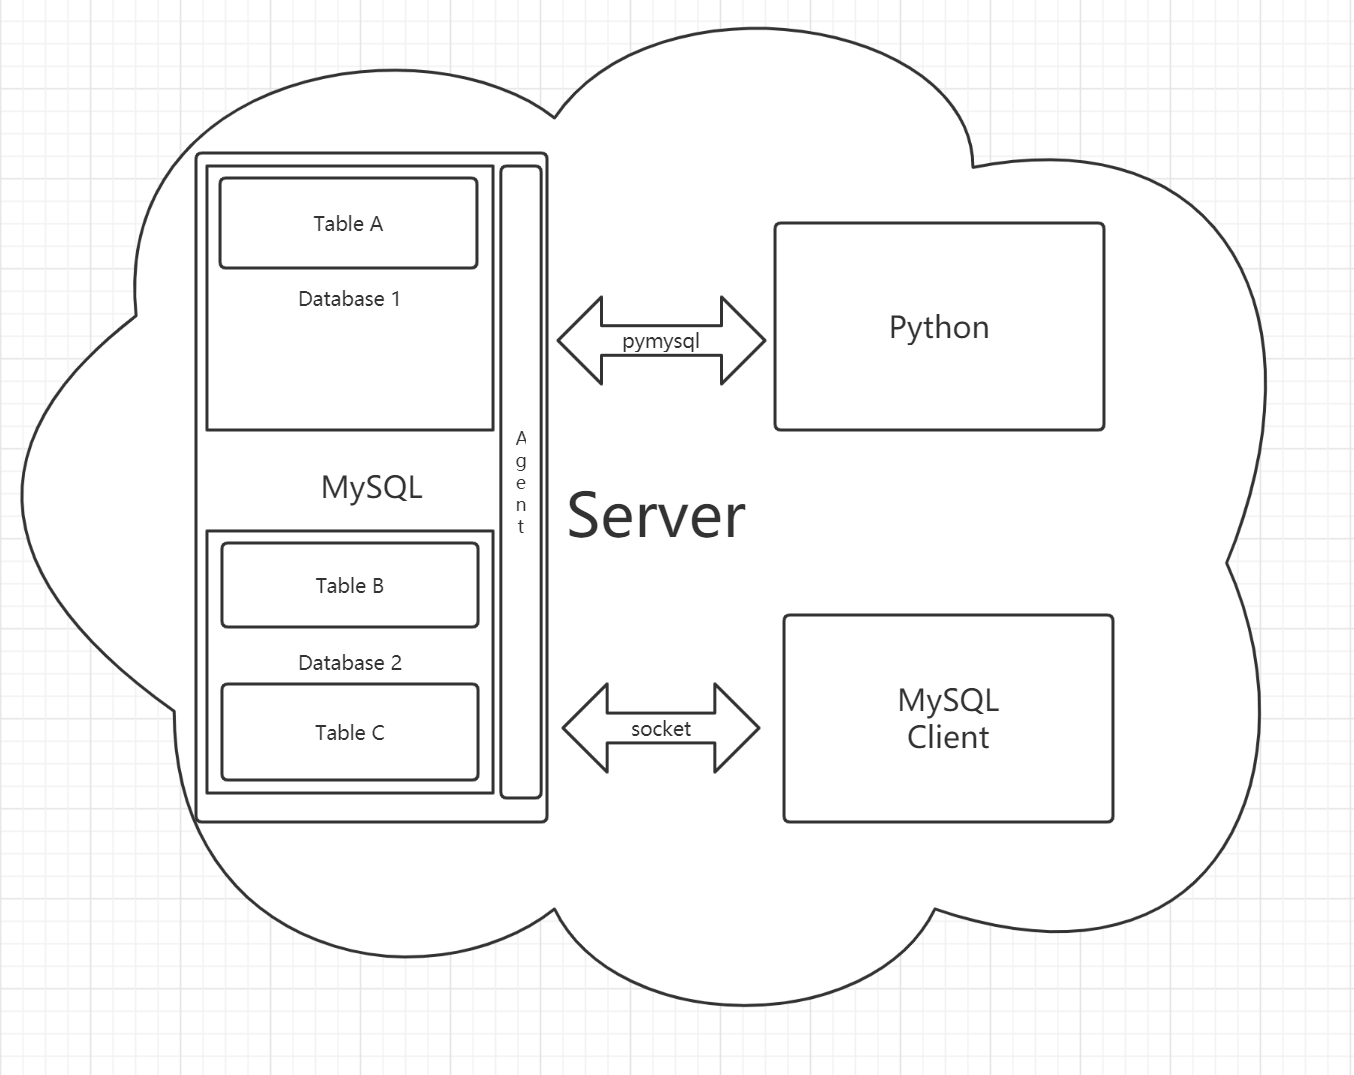

MySQL运行在一台服务器上，其中数据分为两级目录保存：
- Database（库）
- Table（表）

一个MySQL内有可以有多个库，每个库内可以有多个表。当我们执行SQL命令时，并不是直接作用于库或表，而是把SQL告诉MySQL Agent，由MySQL Agent来解析SQL命令并执行相应操作。注意，此处的MySQL Agent只是为了方便理解而抽象的一个概念，在MySQL实际内部构造中，指代的是包括连接池、解析器、优化器等组件共同组成的、位于连接请求和储存引擎之间的组件集合。

库好比Excel，表好比Sheet：一个电脑上有Excel，每个Excel有多个Sheet；我们通过键盘鼠标点击操作，电脑系统解析我们的操作，并转化为对实际文件的操作。切换Database就好比切换不同的Excel文件。切换Table就好比切换一个Excel文件内的不同Sheet。

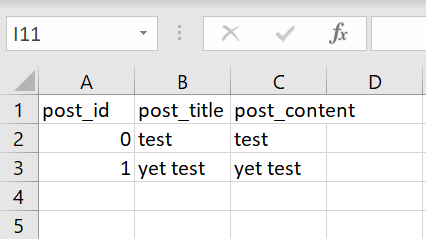

## 常用MySQL语句

打印所有数据库名：
```sql
SHOW DATABASES;
```

建库：
```sql
CREATE DATABASE IF NOT EXISTS markyfsun;
```

更改当前操作的数据库：
```sql
USE markyfsun;
```

打印当前数据库下所有表名：
```sql
SHOW TABLES;
```

建表：
```sql
CREATE TABLE IF NOT EXISTS `lgulife_post`(
   `post_id` INT UNSIGNED COMMENT '帖子ID',
   `post_title` VARCHAR(40) NOT NULL COMMENT '帖子标题',
   `post_content` TEXT NOT NULL COMMENT '帖子内容',
   PRIMARY KEY ( `post_id` ) /* 因为post_id可以唯一确定一个帖子，所以将其设为主键 */
)ENGINE=InnoDB DEFAULT CHARSET=utf8mb4 COMMENT '储存帖子信息的表';
```

打印表信息：
```sql
DESCRIBE lgulife_post;
```

插入数据（IGNORE忽略错误）：
```sql
INSERT IGNORE INTO `lgulife_post` (`post_id`,`post_title`,`post_content`) VALUES 
(0,'test','test'),
(2,'also test','also test'),
(4,'still test','still test'),
(3,'another test','another test'),
(1,'yet test','yet test');
```

查询数据（限制前3条）：
```sql
SELECT post_id,post_title,post_content from `lgulife_post` LIMIT 3;
```

### 为爬虫设计表结构

LGULife上每个帖子都有一个由纯正整数组成的唯一ID，每个帖子也都有字符串格式的标题和内容。为了储存帖子ID、标题和内容，我们需要预先设定它们对应的MySQL数据类型：

- 正整数 $\rightarrow$ INT UNSIGNED：因为不存在负数，所以使用无符号整数，可以提高磁盘空间利用率
- 字符 $\rightarrow$ VARCHAR(40)：因为帖子标题不超过40个字符，这里使用上限长度40的变长字符来储存.为了提高储存效率，VARCHAR长度一般不超过255
- 长字符 $\rightarrow$ TEXT：用来储存长字符串

注意，这里的数据类型不是唯一选择，在不同场景需求下可能需要设置不同的数据类型。

### 练习

现在要为LGULife的帖子评论设计一个表，已知评论有如下属性：
- ID（正整数）
- 评论人昵称（不超过10字）
- 评论内容（不超过200字）

请设计一个```lgulife_comment```表，写出建表语句、插入5条任意数据、查询前2条。

### Python与MySQL交互

```pymysql```库提供了Python与MySQL交互的渠道。通过```.connect```方法，我们可以建起Python与MySQL的连接。

In [34]:
import pymysql

db = pymysql.connect(host='localhost',user='root',passwd='crawlme@2021FALL',charset='utf8mb4')
print(db)

```pymysql```提供了一种游标对象。通过操纵游标，我们可以执行SQL语句并读取相应返回。通过```.cursor```方法获得游标。

In [35]:
cursor = db.cursor(cursor=pymysql.cursors.DictCursor) # 要求游标返回的数据以字典形式呈现
print(cursor)

游标就像是一个魔法抽屉：我们把SQL命令放进去，合上抽屉，再打开时抽屉里就是我们想要的结果。通过游标的```.execute```方法，我们可以执行SQL语句。通过```.fetchone```、```.fetchall```方法，我们可以获得执行的返回结果。

In [36]:
cursor.execute('CREATE DATABASE IF NOT EXISTS markyfsun：')
cursor.execute('USE markyfsun;')
cursor.execute('''
CREATE TABLE IF NOT EXISTS `lgulife_post`(
   `post_id` INT UNSIGNED COMMENT '帖子ID',
   `post_title` VARCHAR(40) NOT NULL COMMENT '帖子标题',
   `post_content` TEXT NOT NULL COMMENT '帖子内容',
   PRIMARY KEY ( `post_id` ) /* 因为post_id可以唯一确定一个帖子，所以将其设为主键 */
)ENGINE=InnoDB DEFAULT CHARSET=utf8mb4 COMMENT '储存帖子信息的表';
''')
cursor.execute('''
INSERT IGNORE INTO `lgulife_post` (`post_id`,`post_title`,`post_content`) VALUES 
(0,'test','test'),
(2,'also test','also test'),
(4,'still test','still test'),
(3,'another test','another test'),
(1,'yet test','yet test');
''')
cursor.execute('''
SELECT post_id,post_title,post_content from `lgulife_post` LIMIT 3;
''')
print(cursor.fetchall()) # 获得全部返回结果，是一个列表，列表内元素均是字典

[{'post_id': 0, 'post_title': 'test', 'post_content': 'test'}, {'post_id': 1, 'post_title': 'yet test', 'post_content': 'yet test'}, {'post_id': 2, 'post_title': 'also test', 'post_content': 'also test'}]


In [37]:
cursor.execute('SHOW TABLES;')
print(cursor.fetchone()) # 获得第一条返回结果，是字典

{'Tables_in_markyfsun': 'lgulife_post'}


In [38]:
cursor.execute('DESCRIBE lgulife_post')
print(cursor.fetchall()) # 获得全部返回结果，是一个列表，列表内元素均是字典

[{'Field': 'post_id', 'Type': 'int unsigned', 'Null': 'NO', 'Key': 'PRI', 'Default': None, 'Extra': ''}, {'Field': 'post_title', 'Type': 'varchar(40)', 'Null': 'NO', 'Key': '', 'Default': None, 'Extra': ''}, {'Field': 'post_content', 'Type': 'text', 'Null': 'NO', 'Key': '', 'Default': None, 'Extra': ''}]


在交互完成后，我们需要主动关闭连接，以免占用服务端资源。

In [39]:
cursor.close()
db.close()

### 练习

用```pymysql```在MySQL中建立一个以自己英文名命名的库，在库中建立一个```lgulife_comment```表，并执行数据插入和查询。

拓展：使用上下文(with...as...)实现上述功能，注意```pymysql.connect```和`.cursor`返回的对象均已经实现了`__enter__`和`__exit__`方法。